In [1]:
import os
import gc
import sys
import time
import math
from datetime import datetime
import tensorboard
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from multiprocessing import Process, Value, Manager
from tensorflow.python.client import device_lib
import pandas as pd
import gc
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Functions of metric learning."""

import tensorflow as tf


@tf.function
def pairwise_distance(feature, squared: bool = False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    pairwise_distances_squared = tf.math.add(
        tf.math.reduce_sum(tf.math.square(feature), axis=[1], keepdims=True),
        tf.math.reduce_sum(
            tf.math.square(tf.transpose(feature)), axis=[0], keepdims=True
        ),
    ) - 2.0 * tf.matmul(feature, tf.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = tf.math.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = tf.math.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = tf.math.sqrt(
            pairwise_distances_squared
            + tf.cast(error_mask, dtype=tf.dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = tf.math.multiply(
        pairwise_distances,
        tf.cast(tf.math.logical_not(error_mask), dtype=tf.dtypes.float32),
    )

    num_data = tf.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = tf.ones_like(pairwise_distances) - tf.linalg.diag(
        tf.ones([num_data])
    )
    pairwise_distances = tf.math.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances


@tf.function
def angular_distance(feature):
    """Computes the angular distance matrix.

    output[i, j] = 1 - cosine_similarity(feature[i, :], feature[j, :])

    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.

    Returns:
      angular_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    # normalize input
    feature = tf.math.l2_normalize(feature, axis=1)

    # create adjaceny matrix of cosine similarity
    angular_distances = 1 - tf.matmul(feature, feature, transpose_b=True)

    # ensure all distances > 1e-16
    angular_distances = tf.maximum(angular_distances, 0.0)

    return angular_distances


In [5]:
class LossFunctionWrapper(tf.keras.losses.Loss):
    """Wraps a loss function in the `Loss` class."""

    def __init__(
        self, fn, reduction=tf.keras.losses.Reduction.AUTO, name=None, **kwargs
    ):
        """Initializes `LossFunctionWrapper` class.

        Args:
          fn: The loss function to wrap, with signature `fn(y_true, y_pred,
            **kwargs)`.
          reduction: (Optional) Type of `tf.keras.losses.Reduction` to apply to
            loss. Default value is `AUTO`. `AUTO` indicates that the reduction
            option will be determined by the usage context. For almost all cases
            this defaults to `SUM_OVER_BATCH_SIZE`. When used with
            `tf.distribute.Strategy`, outside of built-in training loops such as
            `tf.keras` `compile` and `fit`, using `AUTO` or `SUM_OVER_BATCH_SIZE`
            will raise an error. Please see this custom training [tutorial](
              https://www.tensorflow.org/tutorials/distribute/custom_training)
            for more details.
          name: (Optional) name for the loss.
          **kwargs: The keyword arguments that are passed on to `fn`.
        """
        super().__init__(reduction=reduction, name=name)
        self.fn = fn
        self._fn_kwargs = kwargs

    def call(self, y_true, y_pred):
        """Invokes the `LossFunctionWrapper` instance.

        Args:
          y_true: Ground truth values.
          y_pred: The predicted values.

        Returns:
          Loss values per sample.
        """
        return self.fn(y_true, y_pred, **self._fn_kwargs)

    def get_config(self):
        config = {}
        for k, v in iter(self._fn_kwargs.items()):
            config[k] = tf.keras.backend.eval(v) if is_tensor_or_variable(v) else v
        base_config = super().get_config()
        return {**base_config, **config}

In [6]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implements triplet loss."""

import tensorflow as tf
from typing import Optional, Union, Callable


def _masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = tf.math.reduce_min(data, dim, keepdims=True)
    masked_maximums = (
        tf.math.reduce_max(
            tf.math.multiply(data - axis_minimums, mask), dim, keepdims=True
        )
        + axis_minimums
    )
    return masked_maximums


def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums


@tf.function
def triplet_semihard_loss(
    y_true,
    y_pred,
    margin = 1.0,
    distance_metric = "L2",
) -> tf.Tensor:
    r"""Computes the triplet loss with semi-hard negative mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=2.4142137>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix

    if distance_metric == "L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    batch_size = tf.size(labels)

    # Compute the mask.
    pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])
    mask = tf.math.logical_and(
        tf.tile(adjacency_not, [batch_size, 1]),
        tf.math.greater(
            pdist_matrix_tile, tf.reshape(tf.transpose(pdist_matrix), [-1, 1])
        ),
    )
    mask_final = tf.reshape(
        tf.math.greater(
            tf.math.reduce_sum(
                tf.cast(mask, dtype=tf.dtypes.float32), 1, keepdims=True
            ),
            0.0,
        ),
        [batch_size, batch_size],
    )
    mask_final = tf.transpose(mask_final)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    mask = tf.cast(mask, dtype=tf.dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = tf.reshape(
        _masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size]
    )
    negatives_outside = tf.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = tf.tile(
        _masked_maximum(pdist_matrix, adjacency_not), [1, batch_size]
    )
    semi_hard_negatives = tf.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = tf.math.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = tf.math.reduce_sum(mask_positives)

    triplet_loss = tf.math.truediv(
        tf.math.reduce_sum(
            tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
        ),
        num_positives,
    )

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss


@tf.function
def triplet_hard_loss(
    y_true,
    y_pred,
    margin = 1.0,
    soft: bool = False,
    distance_metric = "L2",
) -> tf.Tensor:
    r"""Computes the triplet loss with hard negative and hard positive mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_hard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_hard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=0.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      soft: Boolean, if set, use the soft margin version.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    if distance_metric == "L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    # hard negatives: smallest D_an.
    hard_negatives = _masked_minimum(pdist_matrix, adjacency_not)

    batch_size = tf.size(labels)

    adjacency = tf.cast(adjacency, dtype=tf.dtypes.float32)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # hard positives: largest D_ap.
    hard_positives = _masked_maximum(pdist_matrix, mask_positives)

    if soft:
        triplet_loss = tf.math.log1p(tf.math.exp(hard_positives - hard_negatives))
    else:
        triplet_loss = tf.maximum(hard_positives - hard_negatives + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss


class TripletSemiHardLoss(LossFunctionWrapper):
    """Computes the triplet loss with semi-hard negative mining.

    The loss encourages the positive distances (between a pair of embeddings
    with the same labels) to be smaller than the minimum negative distance
    among which are at least greater than the positive distance plus the
    margin constant (called semi-hard negative) in the mini-batch.
    If no such negative exists, uses the largest negative distance instead.
    See: https://arxiv.org/abs/1503.03832.

    We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
    `[batch_size]` of multi-class integer labels. And embeddings `y_pred` must be
    2-D float `Tensor` of l2 normalized embedding vectors.

    Args:
      margin: Float, margin term in the loss definition. Default value is 1.0.
      name: Optional name for the op.
    """

    def __init__(
        self,
        margin = 1.0,
        distance_metric = "L2",
        name = None,
        **kwargs,
    ):
        super().__init__(
            triplet_semihard_loss,
            name=name,
            reduction=tf.keras.losses.Reduction.NONE,
            margin=margin,
            distance_metric=distance_metric,
        )


class TripletHardLoss(LossFunctionWrapper):
    """Computes the triplet loss with hard negative and hard positive mining.

    The loss encourages the maximum positive distance (between a pair of embeddings
    with the same labels) to be smaller than the minimum negative distance plus the
    margin constant in the mini-batch.
    The loss selects the hardest positive and the hardest negative samples
    within the batch when forming the triplets for computing the loss.
    See: https://arxiv.org/pdf/1703.07737.

    We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
    `[batch_size]` of multi-class integer labels. And embeddings `y_pred` must be
    2-D float `Tensor` of l2 normalized embedding vectors.

    Args:
      margin: Float, margin term in the loss definition. Default value is 1.0.
      soft: Boolean, if set, use the soft margin version. Default value is False.
      name: Optional name for the op.
    """

    def __init__(
        self,
        margin = 1.0,
        soft: bool = False,
        distance_metric = "L2",
        name = None,
        **kwargs,
    ):
        super().__init__(
            triplet_hard_loss,
            name=name,
            reduction=tf.keras.losses.Reduction.NONE,
            margin=margin,
            soft=soft,
            distance_metric=distance_metric,
        )


In [7]:
tf.__version__

'2.9.1'

In [66]:
class TransformerBlockSparse(tf.keras.layers.Layer):
    def __init__(self):
        super(TransformerBlockSparse, self).__init__()

        self.attention1 = tfm.nlp.layers.BigBirdAttention(
                                                            num_rand_blocks=3,
                                                            from_block_size=64,
                                                            to_block_size=64,
                                                            max_rand_mask_length=1000,
                                                            seed=None,
                                                            num_heads=4,
                                                            key_dim=10
                                                        )   #tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=10)
        self.drop1 = tf.keras.layers.Dropout(0.1)
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.attention2 = tfm.nlp.layers.BigBirdAttention(
                                                            num_rand_blocks=3,
                                                            from_block_size=64,
                                                            to_block_size=64,
                                                            max_rand_mask_length=1000,
                                                            seed=None,
                                                            num_heads=4,
                                                            key_dim=10
                                                        )   #tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=10)
        self.drop2 = tf.keras.layers.Dropout(0.1)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(10, activation="relu")
        self.dense2 = tf.keras.layers.Dense(10, activation="relu")
        self.drop3 = tf.keras.layers.Dropout(0.1)
        self.drop4 = tf.keras.layers.Dropout(0.1)
        self.batch3 = tf.keras.layers.BatchNormalization()

    def call(self, src):
        data = src + 0

        att = self.attention1(data, data, data, attention_mask=tf.constant(0, shape=(4, 1000)))
        data = data + self.drop1(att)
        data = self.batch1(data)
        att = self.attention2(data, data, data, attention_mask=tf.constant(0, shape=(4, 1000)))
        data = data + self.drop2(att)
        data = self.batch2(data)
        att = self.dense2(self.drop3(self.dense1(data)))
        data = data + self.drop4(att)
        data = self.batch3(data)

        return data
    

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(TransformerBlock, self).__init__()

        self.attention1 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=100)
        self.drop1 = tf.keras.layers.Dropout(0.1)
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.attention2 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=100)
        self.drop2 = tf.keras.layers.Dropout(0.1)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(64, activation="relu")
        self.dense2 = tf.keras.layers.Dense(64, activation="relu")
        self.drop3 = tf.keras.layers.Dropout(0.1)
        self.drop4 = tf.keras.layers.Dropout(0.1)
        self.batch3 = tf.keras.layers.BatchNormalization()

    def call(self, src):
        data = src + 0

        att = self.attention1(data, data)
        data = data + self.drop1(att)
        data = self.batch1(data)
        att = self.attention2(data, data)
        data = data + self.drop2(att)
        data = self.batch2(data)
        att = self.dense2(self.drop3(self.dense1(data)))
        data = data + self.drop4(att)
        data = self.batch3(data)

        return data


class KINT(tf.keras.Model):
    def __init__(self):
        super(KINT, self).__init__()
        
        self.norm = tf.keras.layers.LayerNormalization()

        self.conv1 = tf.keras.layers.Conv1D(128, 20, padding='same', activation="relu")
        self.conv2 = tf.keras.layers.Conv1D(128, 20, padding='same', activation="relu")
        self.conv3 = tf.keras.layers.Conv1D(128, 20, padding='same', activation="relu")
        self.conv4 = tf.keras.layers.Conv1D(128, 20, padding='same', activation="relu")
        self.conv5 = tf.keras.layers.Conv1D(256, 15, padding='same', activation="relu")
        self.conv6 = tf.keras.layers.Conv1D(256, 15, padding='same', activation="relu")
        self.conv7 = tf.keras.layers.Conv1D(256, 15, padding='same', activation="relu")
        self.conv8 = tf.keras.layers.Conv1D(256, 15, padding='same', activation="relu")

        self.batch1 = tf.keras.layers.BatchNormalization()
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.batch4 = tf.keras.layers.BatchNormalization()
        self.batch5 = tf.keras.layers.BatchNormalization()
        self.batch6 = tf.keras.layers.BatchNormalization()
        self.batch7 = tf.keras.layers.BatchNormalization()
        self.batch8 = tf.keras.layers.BatchNormalization()

        self.pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)
        self.pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)
        self.pool3 = tf.keras.layers.MaxPooling1D(pool_size=5)

        self.flat = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation="relu")
        self.dense2 = tf.keras.layers.Dense(128, activation="relu")
        # self.dense3 = tf.keras.layers.Dense(10, activation="softmax")
        self.dense3 = tf.keras.layers.Dense(128, activation=None)  # No activation on final dense layer
        self.l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # L2 normalize embeddings

    def call(self, src):
        output = self.norm(src)
        
        # here will be outputs of the each layer
        output = self.conv1(output)  # (32, 500, 1024)
        output = self.batch1(output)

        output = self.conv2(output)
        output = self.batch2(output)

        # output = self.attention1(output, output)
        output = self.pool1(output)  # (32, 250, 1024)

        output = self.conv3(output)  # (32, 250, 1024)
        output = self.batch3(output)

        output = self.conv4(output)
        output = self.batch4(output)

        # output = self.attention2(output, output)
        output = self.pool2(output)  # (32, 125, 1024)

        output = self.conv5(output)  # (32, 125, 1024)
        output = self.batch5(output)

        output = self.conv6(output)
        output = self.batch6(output)

        # output = self.attention3(output, output)
        output = self.pool3(output)  # (32, 25, 1024)

        output = self.conv7(output)  # (32, 25, 1024)
        output = self.batch7(output)

        output = self.conv8(output)
        output = self.batch8(output)

        # output = tf.reshape(output, [32, 1600])

        output = self.flat(output)
        output = self.dense1(output)
        output = self.dense2(output)
        output = self.dense3(output)
        output = self.l2(output)

        # output = tf.reshape(output, [2, 10])
        # output = tf.nn.softmax(output)
        # output = tf.keras.activations.softmax(output)

        return output

    def build_graph(self):
        self.build((32, 1000, 5))
        inputs = tf.keras.Input(shape=[1000, 5])
        self.call(inputs)
        
        
class TransformerSparse(tf.keras.Model):
    def __init__(self):
        super(Transformer, self).__init__()
        
        self.norm = tf.keras.layers.LayerNormalization()
        
        self.conv1 = tf.keras.layers.Conv1D(16, 16, padding='same', activation="relu")
        self.conv2 = tf.keras.layers.Conv1D(16, 16, padding='same', activation="relu")
        self.conv3 = tf.keras.layers.Conv1D(16, 16, padding='same', activation="relu")
        self.conv4 = tf.keras.layers.Conv1D(16, 16, padding='same', activation="relu")
        self.conv5 = tf.keras.layers.Conv1D(16, 8, padding='same', activation="relu")
        self.conv6 = tf.keras.layers.Conv1D(16, 8, padding='same', activation="relu")
        self.conv7 = tf.keras.layers.Conv1D(16, 8, padding='same', activation="relu")
        self.conv8 = tf.keras.layers.Conv1D(16, 8, padding='same', activation="relu")

        self.batch1 = tf.keras.layers.BatchNormalization()
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.batch4 = tf.keras.layers.BatchNormalization()
        self.batch5 = tf.keras.layers.BatchNormalization()
        self.batch6 = tf.keras.layers.BatchNormalization()
        self.batch7 = tf.keras.layers.BatchNormalization()
        self.batch8 = tf.keras.layers.BatchNormalization()

        self.pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)
        self.pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)
        self.pool3 = tf.keras.layers.MaxPooling1D(pool_size=5)


#         self.dense_init = tf.keras.layers.Dense(10, activation="elu")
        self.transformer1 = TransformerBlock()
        self.transformer2 = TransformerBlock()
        self.transformer3 = TransformerBlock()
        self.flat = tf.keras.layers.Flatten()
        self.dense_last = tf.keras.layers.Dense(128, activation=None)
        self.l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # L2 normalize embeddings

    def call(self, src):
        
        output = self.norm(src)
        
#         output = self.dense_init(output)
        
        output = self.transformer1(output)
        output = self.transformer2(output)
        output = self.transformer3(output)
        
        output = self.conv1(output)  # (32, 500, 1024)
        output = self.batch1(output)

        output = self.conv2(output)
        output = self.batch2(output)

        # output = self.attention1(output, output)
        output = self.pool1(output)  # (32, 250, 1024)

        output = self.conv3(output)  # (32, 250, 1024)
        output = self.batch3(output)

        output = self.conv4(output)
        output = self.batch4(output)

        # output = self.attention2(output, output)
        output = self.pool2(output)  # (32, 125, 1024)

        output = self.conv5(output)  # (32, 125, 1024)
        output = self.batch5(output)

        output = self.conv6(output)
        output = self.batch6(output)

        # output = self.attention3(output, output)
        output = self.pool3(output)  # (32, 25, 1024)

        output = self.conv7(output)  # (32, 25, 1024)
        output = self.batch7(output)

        output = self.conv8(output)
        output = self.batch8(output)
        
        output = self.flat(output)
        output = self.dense_last(output)
        output = self.l2(output)

        return output

    def build_graph(self):
#         self.build(tf.constant(0, shape=(64, 1000, 5)))
#         self.build((64, 1000, 5))
#         inputs = tf.keras.Input(shape=[1000, 5])
#         self.call(inputs)
        self.call(tf.constant(0, shape=(64, 1000, 5)))
    
    
class Transformer(tf.keras.Model):
    def __init__(self):
        super(Transformer, self).__init__()
        
        self.norm = tf.keras.layers.LayerNormalization()
        
        self.embedding = tf.keras.layers.Dense(64, activation=None)
        
        self.transformer1 = TransformerBlock()
        self.transformer2 = TransformerBlock()
        self.transformer3 = TransformerBlock()
        
        
        self.dense_last = tf.keras.layers.Dense(128, activation=None)
        self.l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # L2 normalize embeddings

    def call(self, src):
        
        output = self.norm(src)
        
        output = self.embedding(output)
        
        output = self.transformer1(output)
        output = self.transformer2(output)
        output = self.transformer3(output)
        
        output = output[:, 0, :]
        
        output = self.dense_last(output)
        output = self.l2(output)

        return output

    def build_graph(self):
        self.build((64, 200, 5))
        inputs = tf.keras.Input(shape=[200, 5])
        self.call(inputs)



def scheduler(epoch, lr):
    print('LEARNING RATE:', round(lr, 8))
    if epoch < 10:
        return lr
    else:
        return 0.00005


class LearningRateTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_decayed_lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print("current decayed lr: {:0.7f}".format(current_decayed_lr))

In [27]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, path, type, batch_size):

        self.batch_size = batch_size

        self.all_inputs = np.load(path + 'all_inputs_{}articlefixed.npy'.format(type))[:, ::5, :5]
        self.all_targets = np.load(path + 'all_targets_{}articlefixed.npy'.format(type))
        
        
        allowed = []
        
        for i in range(len(self.all_inputs)):
            if np.all(self.all_inputs[i, :, 0] == 0.) or np.all(self.all_inputs[i, :, 0] == 10.):
                allowed.append(False)
            else:
                allowed.append(True)
                
        self.all_inputs = self.all_inputs[allowed]
        self.all_targets = self.all_targets[allowed]
        
        
        mean = self.all_inputs.mean()
        std = self.all_inputs.std()
        self.all_inputs = (self.all_inputs - mean) / std
        
        print(f'Mean = {mean}, std = {std}')
        
        
        print(self.all_inputs.shape, self.all_targets.shape)
        
        self.on_epoch_end()

    def __getitem__(self, index):
        input = self.all_inputs[index * self.batch_size:(index + 1) * self.batch_size]
        target = self.all_targets[index * self.batch_size:(index + 1) * self.batch_size]
        target = np.argmax(target, axis=-1).squeeze()

        return input, target

    def on_epoch_end(self):
        randomize = np.arange(len(self.all_inputs))
        np.random.shuffle(randomize)
        self.all_inputs = self.all_inputs[randomize]
        self.all_targets = self.all_targets[randomize]

    def __len__(self):
        return math.floor(len(self.all_inputs) / self.batch_size)

In [74]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.9,
    staircase=True)

model = Transformer()
model.build_graph()
# model(tf.keras.Input(shape=[1000, 5]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=TripletSemiHardLoss(margin=0.2))
# print("First learning rate: ", round(model.optimizer.lr.numpy(), 5))
model.summary()

print("Making training dataset...", flush=True)
train_d = DataGen('./', 'train', 512)
print("Making testing dataset...", flush=True)
valid_d = DataGen('./', 'test', 512)

print("Training...", flush=True)

checkpoint_path = f"model_transformer_triplet_loss.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min')


logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
the_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
lr_tracker = LearningRateTracker()
history = model.fit(train_d, validation_data=valid_d, epochs=20, batch_size=512, callbacks=[cp_callback, the_scheduler, tensorboard_callback], verbose=1)
print("Learning finished")

Model: "transformer_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_21 (Lay  (None, 200, 5)           10        
 erNormalization)                                                
                                                                 
 dense_168 (Dense)           (None, 200, 64)           384       
                                                                 
 transformer_block_63 (Trans  (None, 200, 64)          216416    
 formerBlock)                                                    
                                                                 
 transformer_block_64 (Trans  (None, 200, 64)          216416    
 formerBlock)                                                    
                                                                 
 transformer_block_65 (Trans  (None, 200, 64)          216416    
 formerBlock)                                       

# Testing

In [76]:
with open('SM_new.pickle', 'rb') as handle:
    SM = pickle.load(handle)

In [77]:
SM_processed = SM.copy()

SM_processed[:, 0] *= 10
SM_processed[:, 1] *= 10
SM_processed[:, 2] *= 10
SM_processed[:, 3] *= 1000000
SM_processed[:, 4] *= 1000000

In [78]:
SM_processed = np.expand_dims(SM_processed, axis=0)[:, ::5, :]
SM_processed.shape

(1, 200, 5)

In [79]:
model = Transformer()
model.build_graph()

axis1 = 1
axis2 = 120

model.summary()
model.load_weights("model_transformer_triplet_loss.hdf5")

input_test = np.load('./all_inputs_testarticlefixed.npy')[:, ::5, :5]
target_test = np.load('./all_targets_testarticlefixed.npy')

allowed = []
        
for i in range(len(input_test)):
    if np.all(input_test[i, :, 0] == 0.) or np.all(input_test[i, :, 0] == 10.):
        allowed.append(False)
    else:
        allowed.append(True)

input_test = input_test[allowed]
target_test = target_test[allowed]

print(input_test.shape)
mean = input_test.mean()
std = input_test.std()
input_test = (input_test - mean) / std

# print(target_test[1000:2000])
results_test = model.predict(input_test)

input_train = np.load('./all_inputs_trainarticlefixed.npy')[:, ::5, :5]
target_train = np.load('./all_targets_trainarticlefixed.npy')

allowed = []
        
for i in range(len(input_train)):
    if np.all(input_train[i, :, 0] == 0.) or np.all(input_train[i, :, 0] == 10.):
        allowed.append(False)
    else:
        allowed.append(True)

input_train = input_train[allowed]
target_train = target_train[allowed]

mean = input_train.mean()
std = input_train.std()
input_train = (input_train - mean) / std
results_train = model.predict(input_train)

# real data
SM_processed = (SM_processed - mean) / std
real_data_pred = model.predict(SM_processed)

Model: "transformer_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_23 (Lay  (None, 200, 5)           10        
 erNormalization)                                                
                                                                 
 dense_184 (Dense)           (None, 200, 64)           384       
                                                                 
 transformer_block_69 (Trans  (None, 200, 64)          216416    
 formerBlock)                                                    
                                                                 
 transformer_block_70 (Trans  (None, 200, 64)          216416    
 formerBlock)                                                    
                                                                 
 transformer_block_71 (Trans  (None, 200, 64)          216416    
 formerBlock)                                       

Predicted class: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
The distance between real data and closest item from train dataset 0.07669193297624588


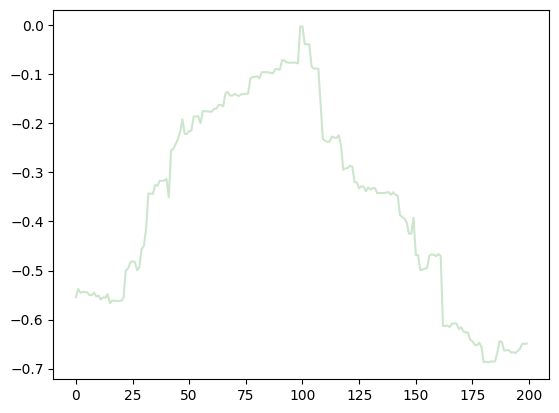

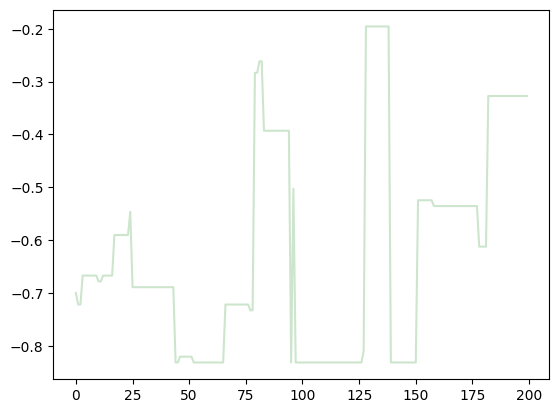

Chosen file from train dataset: 1301_0.014285_0.0294_0G.txt
Classes of 30 closest samples: [13 12 12 12 13 12 11 13 14 12 13 11 13 14 12 11 13 13 12 14 13 12 12 12
 12 14 12 13 13 12]
Mean class of those 30: 12.5
Distances to 30 closest samples: [0.07669193 0.09122121 0.09168109 0.09365992 0.0943769  0.10849565
 0.11010516 0.11260192 0.11556906 0.11821727 0.12363376 0.12399125
 0.12415285 0.12531495 0.12657726 0.12659872 0.12665962 0.1293954
 0.13184154 0.133762   0.13526106 0.13566974 0.1358772  0.13729315
 0.13798022 0.13817368 0.1395185  0.14016259 0.14037125 0.14632241]


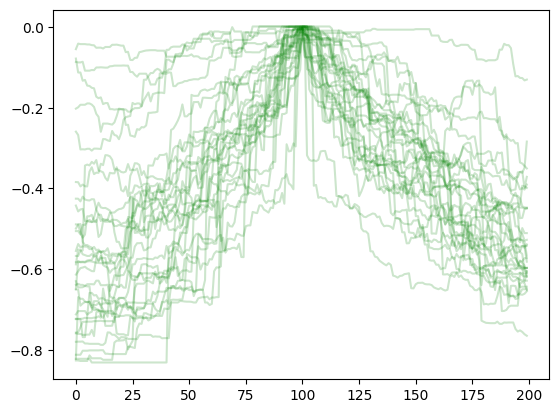

['1301_0.014285_0.0294_0G.txt' '1201_0.014285_0.019_0J.txt'
 '1201_0.014285_0.0209_0B.txt' '1201_0.014285_0.0219_0J.txt'
 '1301_0.014285_0.0465_0H.txt' '1201_0.014285_0.0252_0F.txt'
 '1101_0.014285_0.0175_0H.txt' '1301_0.014285_0.0841_0D.txt'
 '1401_0.014285_0.0469_0C.txt' '1201_0.014285_0.0901_0J.txt'
 '1301_0.014285_0.0318_0J.txt' '1101_0.014285_0.0238_0F.txt'
 '1301_0.014285_0.0224_0G.txt' '1401_0.014285_0.0269_0E.txt'
 '1201_0.014285_0.0232_0J.txt' '1101_0.014285_0.0137_0H.txt'
 '1301_0.014285_0.0283_0A.txt' '1301_0.014285_0.0871_0E.txt'
 '1201_0.014285_0.0806_0D.txt' '1401_0.014285_0.0305_0B.txt'
 '1301_0.014285_0.0212_0E.txt' '1201_0.014285_0.0291_0E.txt'
 '1201_0.014285_0.015_0D.txt' '1201_0.014285_0.0212_0I.txt'
 '1201_0.014285_0.0213_0E.txt' '1401_0.014285_0.0286_0G.txt'
 '1201_0.014285_0.0842_0D.txt' '1301_0.014285_0.0262_0A.txt'
 '1301_0.014285_0.0305_0H.txt' '1201_0.014285_0.021_0H.txt']
Predicted selection coefficient: 0.03560333333333333


In [80]:
nearest_item_to_real_data_arg = np.argmin(np.linalg.norm(real_data_pred[0] - results_train, axis=1))
class_of_real_data = target_train[nearest_item_to_real_data_arg]
print(f'Predicted class: {class_of_real_data}')
print(f'The distance between real data and closest item from train dataset {np.min(np.linalg.norm(real_data_pred[0] - results_train, axis=1))}')

plt.clf()
plt.plot(input_train[nearest_item_to_real_data_arg, :, 0].T, color='green', alpha=0.2)
plt.show()

plt.clf()
plt.plot(SM_processed[0, :, 0], color='green', alpha=0.2)
plt.show()

file_list = np.array(sorted(os.listdir('/home/avshmelev/bash_scripts/selam/next_gen_simulation_articlefixedtrainbigpercent/')))
print(f'Chosen file from train dataset: {file_list[allowed][nearest_item_to_real_data_arg]}')

class_list = np.argmax(target_train[sorted_items := np.argsort(closest_distances_to_real_data := np.linalg.norm(real_data_pred[0] - results_train, axis=1))[:30]], axis=-1).squeeze()
print(f'Classes of 30 closest samples: {class_list}')
print(f'Mean class of those 30: {class_list.mean()}')
print(f'Distances to 30 closest samples: {np.sort(closest_distances_to_real_data)[:30]}')

plt.clf()
plt.plot(input_train[sorted_items][:30, :, 0].T, color='green', alpha=0.2)
plt.show()

print(closest_files := file_list[allowed][sorted_items][:30])

predicted_selection_coeff = []
for i in closest_files:
    predicted_selection_coeff.append(float(i.split('_')[2]))
                                     
print(f'Predicted selection coefficient: {np.array(predicted_selection_coeff).mean()}')

In [52]:
a = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

for i in range(10):
    b = [i for i in a]
    print(b)
    print(i)
    
print('final i', i)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
3
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
4
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
6
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
7
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
8
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
9
final i 9


(9996, 128)
(9996, 128)
(9999, 128)
(9998, 128)
(9996, 128)
(10000, 128)
(9999, 128)
(10000, 128)
(9997, 128)
(9998, 128)
(9999, 128)
(9998, 128)
(10000, 128)
(9997, 128)
(9998, 128)
(9999, 128)
(10000, 128)
(10000, 128)
(9999, 128)
(10000, 128)
[[ 0.02166922 -0.02181176 -0.09021275 ... -0.09504086  0.11079817
  -0.0354193 ]
 [ 0.02276377 -0.02755352 -0.09119305 ... -0.08770363  0.10354843
  -0.03547299]
 [ 0.0232423  -0.03518657 -0.09252486 ... -0.07822838  0.09390684
  -0.03602197]
 ...
 [ 0.05663761  0.02864256  0.07650382 ...  0.13119733 -0.07803357
   0.11209397]
 [-0.04193302  0.10329915  0.03748506 ... -0.02779684 -0.04305629
   0.10999541]
 [-0.1504353   0.05337626 -0.02555256 ... -0.03838371  0.0720114
  -0.0064456 ]]
Distance between clusters 0 and 1 = 0.06286536696289229
Distance between clusters 0 and 2 = 0.14521386635973865
Distance between clusters 0 and 3 = 0.2570904414660748
Distance between clusters 0 and 4 = 0.39510337526907774
Distance between clusters 0 and 5 = 0.56

<Figure size 640x480 with 0 Axes>

<Figure size 10400x10400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

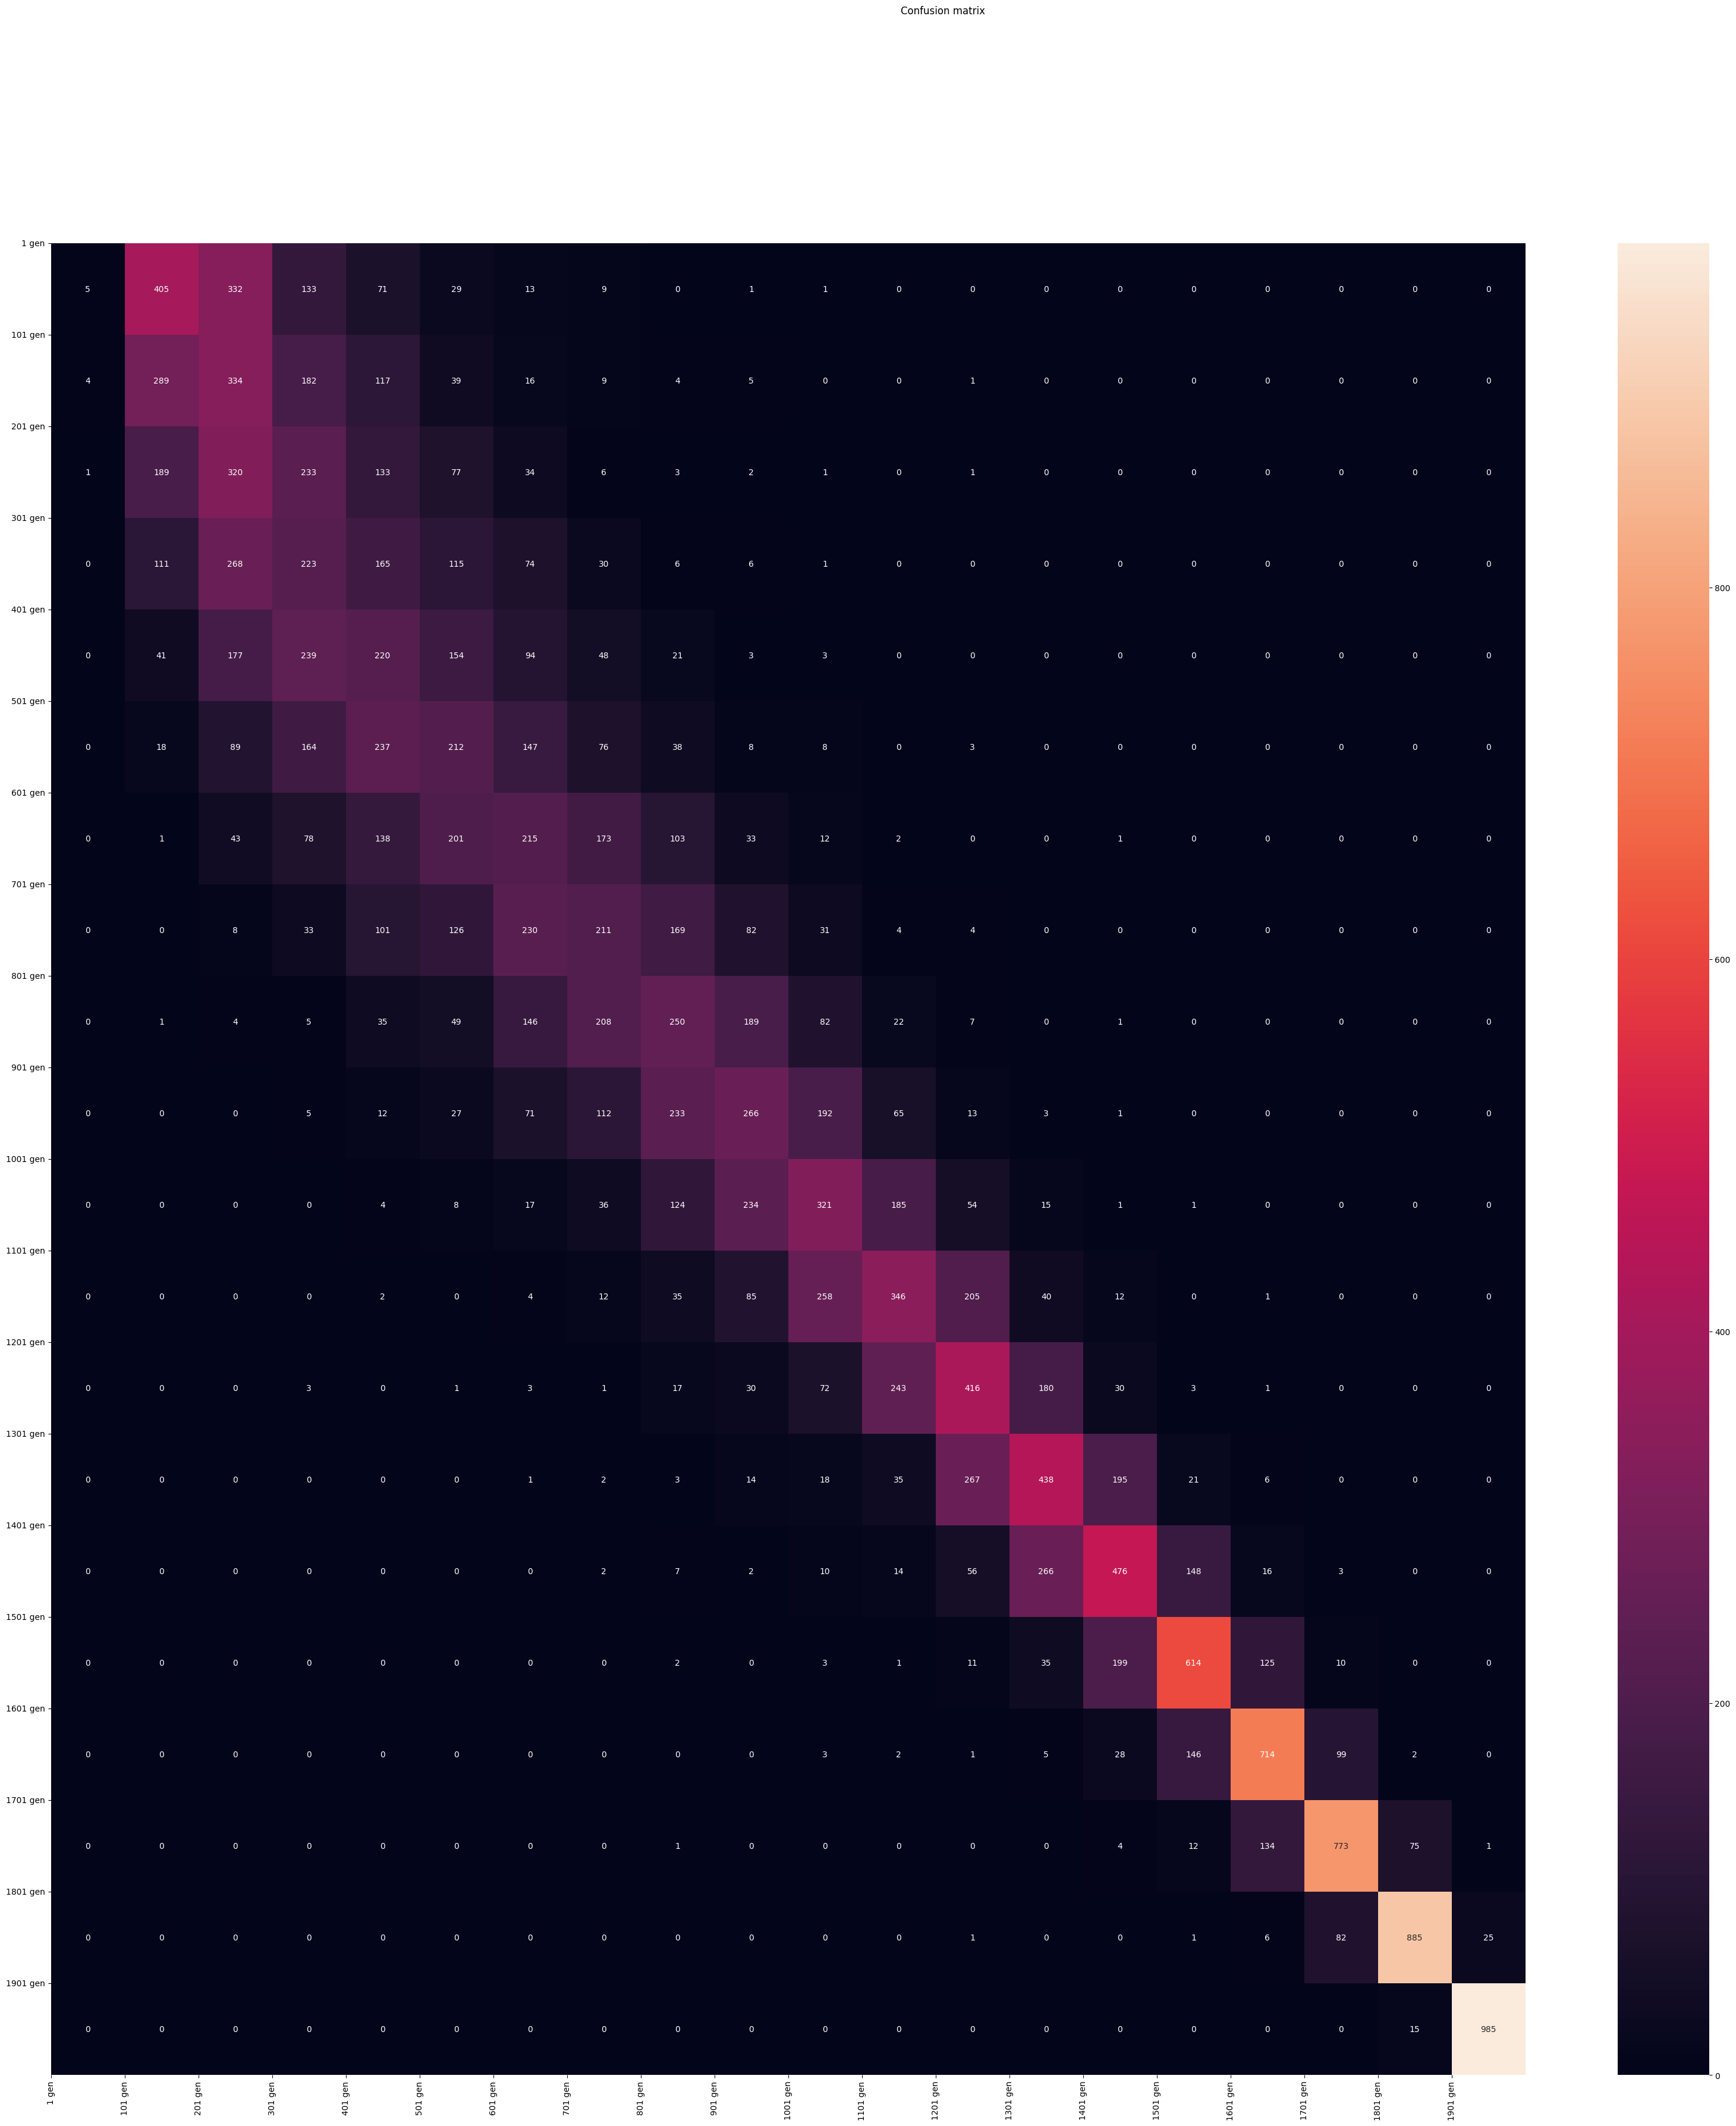

Accuracy: 15230/19996, exactly: 0.7617


In [73]:
px = 1 / plt.rcParams['figure.dpi']
plt.clf()
fig, ax = plt.subplots(10, 2, figsize=(10400 * px, 10400 * px))

tmp_train = []
tmp_test = []
for i in range(20):
    for j, vec in enumerate(results_train):
        if np.argmax(target_train[j]) == i:
            tmp_train.append(vec)
    tmp_train = np.array(tmp_train)
    print(tmp_train.shape)
    projection_train = np.stack((tmp_train[:, axis1], tmp_train[:, axis2]), axis=-1)
    dots1 = ax[i % 10][i // 10].scatter(projection_train[:, 0], projection_train[:, 1], s=10, label='Train data')
    tmp_train = []

    for j, vec in enumerate(results_test):
        if np.argmax(target_test[j]) == i:
            tmp_test.append(vec)
    tmp_test = np.array(tmp_test)
    projection_test = np.stack((tmp_test[:, axis1], tmp_test[:, axis2]), axis=-1)
    dots2 = ax[i % 10][i // 10].scatter(projection_test[:, 0], projection_test[:, 1], s=10, label='Test data')
    tmp_test = []
    
    ax[i % 10][i // 10].plot([real_data_pred[0, axis1]], [real_data_pred[0, axis2]], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")

    ax[i % 10][i // 10].legend(handles=[dots1, dots2], fontsize=40)

for i in range(20):
    ax[i % 10][i // 10].set_title(f"Class {i + 1}", fontsize=40)

fig.suptitle(f"Projection for axes {axis1} and {axis2}", fontsize=80)
fig.savefig("projection.png")

# projection = np.stack((results_train[:, 128], results_train[:, 988]), axis=-1)
# print(projection.shape)
# plt.clf()
# plt.scatter(projection[:, 0], projection[:, 1], s=0.1)
# plt.show()

clusters = np.zeros((20, 128))
tmp = []
for i in range(20):
    for j, vec in enumerate(results_train):
        if np.argmax(target_train[j].squeeze()) == i:
            tmp.append(vec)
    tmp = np.array(tmp)
    clusters[i, :] = tmp.mean(axis=0)
    tmp = []

print(clusters)

dist = np.zeros((20, 20))
for i in range(20):
    for j in range(i + 1, 20):
        print(f"Distance between clusters {i} and {j} = {np.linalg.norm(clusters[i] - clusters[j])}")
        dist[i, j] = np.linalg.norm(clusters[i] - clusters[j])
        dist[j, i] = np.linalg.norm(clusters[i] - clusters[j])

plt.clf()
fig, ax = plt.subplots(1, 1)
img = ax.imshow(dist)
for (j, i), label in np.ndenumerate(dist):
    ax.text(i, j, round(label, 2), ha='center', va='center', fontsize=6)
fig.colorbar(img)
fig.suptitle("Distances between clusters")
plt.savefig("cluster_distances.png")

# tsne = TSNE(learning_rate=10, perplexity=10)
# embedded = tsne.fit_transform(results_train)
# print('New Shape of X: ', embedded.shape)
# print('Kullback-Leibler divergence after optimization: ', tsne.kl_divergence_)
# print('No. of iterations: ', tsne.n_iter_)
#
# plt.clf()
# fig, ax = plt.subplots(5, 2, figsize=(6400 * px, 6400 * px))
# for i in range(10):
#     for j, vec in enumerate(embedded):
#         if np.argmax(target_train[j].squeeze()) == i:
#             tmp_train.append(vec)
#     tmp_train = np.array(tmp_train)
#     dots = ax[i % 5][i // 5].scatter(tmp_train[:, 0], tmp_train[:, 1], s=10, label=f'Class {i}')
#     tmp_train = []
#     ax[i % 5][i // 5].legend(handles=[dots], fontsize=40)
#
# plt.savefig("New_clusters.png")

# print(target_test[0])
ground_truth = []
predicted_labels = []
counter = 0
for i in range(len(results_test)):
    # for i, vec in enumerate(results_test):
    # if i % 100 == 0:
    print(i)
    vec = results_test[i]
    real = target_test[i]
    norm_arg = np.argmin(np.linalg.norm(vec - results_train, axis=1))
    # print(np.min(np.linalg.norm(vec - results_train, axis=1)))
    # norm_arg = np.argmin(np.linalg.norm(vec - clusters, axis=1))
    answer = target_train[norm_arg]
    print(np.argmax(real.squeeze()), np.argmax(answer.squeeze()))
    class_list = np.argmax(target_train[np.argsort(np.linalg.norm(vec - results_train, axis=1))[:30]],
                           axis=-1).squeeze()
    print(class_list, "Mean class: ", np.mean(class_list))
    print(np.round(np.mean(class_list)))
    # if np.abs(np.argmax(real.squeeze()) - np.argmax(answer.squeeze())) <= 1:
    ground_truth.append(np.argmax(real.squeeze()))
    predicted_labels.append(int(np.round(np.mean(class_list))))
    if np.abs(np.argmax(real.squeeze()) - np.round(np.mean(class_list))) <= 1:
        counter += 1
        
print(classification_report(ground_truth, predicted_labels))
cm = confusion_matrix(ground_truth, predicted_labels)

plt.clf()
    
px = 1 / plt.rcParams['figure.dpi']

fig, ax = plt.subplots(1, 1, figsize=(4000 * px, 4000 * px))
sns.heatmap(cm, annot=True, ax=ax, annot_kws={'size': 10}, fmt='d')
ax.set_xticks([i for i in range(20)])
ax.set_xticklabels([f'{i * 100 + 1} gen' for i in range(20)])
ax.set_yticks([i for i in range(20)])
ax.set_yticklabels([f'{i * 100 + 1} gen' for i in range(20)])
fig.suptitle("Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90) 
plt.savefig(rf"adaptive_introgression_cm.png", bbox_inches="tight")
plt.show()

print(f"Accuracy: {counter}/{len(results_test)}, exactly: {round(counter / len(results_test), 4)}")
# norm_arg = np.argmin(np.linalg.norm(results_test[0] - results_train, axis=1))
# print(target_train[norm_arg])

In [107]:
target_train = np.load('./all_targets_trainarticle.npy')
print(target_train[180001])
print(target_train[20001])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [3]:
input_train = np.load('./all_inputs_trainarticle.npy')[:, ::5, :5]

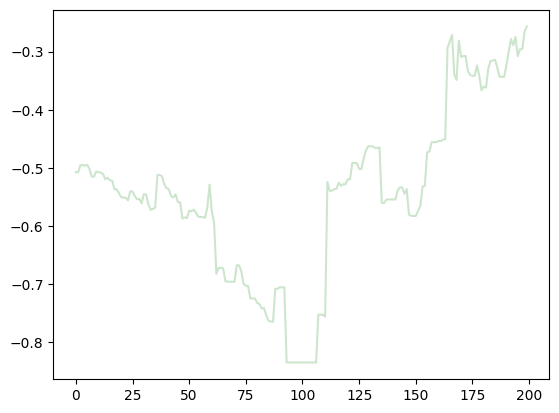

In [40]:
plt.clf()
plt.plot(input_train[1500, :, 2].T, color='green', alpha=0.2)
plt.show()